In [66]:
pip install empath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57798 sha256=7ee9f10c6d0c749c1978933699854ff169c04551fce0238ccdad589fa11648a4
  Stored in directory: /root/.cache/pip/wheels/92/b3/83/9eb2c6199881e2385a59d99bd911363475060ebeb4bdb27242
Successfully built empath


In [32]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
df = pd.read_csv('drive/MyDrive/SMM/sustainable_fashion_data.csv')

In [38]:
df.head()

,post_title,comment_body,comment_score,comment_created_utc,comment_author,reply_count
0,The most sustainable fashion,right? people on here are arguing about what c...,102,1.646939e+09,2001questions,9
1,The most sustainable fashion,Fashion loves a trend. Unfortunately the beast...,29,1.646948e+09,Sintech14,1
2,The most sustainable fashion,"I agree!! As a fashion industry professional,...",51,1.646927e+09,Silver_Rice_8218,7
3,The most sustainable fashion,I believe the problem is also that the clothes...,14,1.650353e+09,EskarinaSmithsstaff,3
4,The most sustainable fashion,The most problematic part of this post is that...,11,1.653594e+09,EcoStylist,0


In [131]:
unique_post_title_count = df['post_title'].nunique()
print(f"Number of unique post titles: {unique_post_title_count}")

Number of unique post titles: 90


In [132]:
df = df.drop('comment_author', axis=1)

**1. Pre-processing**

- Null Values

In [133]:
# Display basic information about dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_title           1300 non-null   object 
 1   comment_body         1300 non-null   object 
 2   comment_score        1300 non-null   int64  
 3   comment_created_utc  1300 non-null   float64
 4   reply_count          1300 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 50.9+ KB
None


- Word Count

In [134]:
# Define a function to remove short comments (less than 5 words)
def remove_short_comments(df):
    # Count short comments (less than 5 words)
    short_comments_count = df[df['comment_body'].apply(lambda x: len(x.split()) < 5)].shape[0]
    print(f"Number of comments with less than 5 words: {short_comments_count}")

    # Add a word_count column to the dataframe
    df['word_count'] = df['comment_body'].apply(lambda x: len(x.split()))

    # Filter out short comments (word count >= 5)
    df = df[df['word_count'] >= 5]

    # Drop the 'word_count' column as it's no longer needed
    df.drop(columns=['word_count'], inplace=True)

    return df

# Apply the function to each dataset
df = remove_short_comments(df)

Number of comments with less than 5 words: 152


<ipython-input-134-b08374f20436>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['word_count'], inplace=True)


- Duplicate comments

In [135]:
df_duplicate = df[df.duplicated(subset='comment_body', keep=False)]
print(f"Number of duplicate comments : {df_duplicate.shape[0]}")

Number of duplicate comments : 4


In [136]:
#drop duplicates
df = df.drop_duplicates(subset='comment_body', keep='first')

In [137]:
#Convert timestamp to datetime
df['comment_created_utc'] = pd.to_datetime(df['comment_created_utc'], unit='s')

- Normalizing Data

In [138]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [139]:
# Apply preprocessing
df['processed_text'] = df['comment_body'].apply(preprocess_text)

In [140]:
df.head()

,post_title,comment_body,comment_score,comment_created_utc,reply_count,processed_text
0,The most sustainable fashion,right? people on here are arguing about what c...,102,2022-03-10 19:01:38,9,right people arguing company actually sustaina...
1,The most sustainable fashion,Fashion loves a trend. Unfortunately the beast...,29,2022-03-10 21:40:50,1,fashion love trend unfortunately beast stopped...
2,The most sustainable fashion,"I agree!! As a fashion industry professional,...",51,2022-03-10 15:38:37,7,agree fashion industry professional almost sus...
3,The most sustainable fashion,I believe the problem is also that the clothes...,14,2022-04-19 07:17:22,3,believe problem also clothes produced low qual...
4,The most sustainable fashion,The most problematic part of this post is that...,11,2022-05-26 19:33:22,0,problematic part post seems completely unaware...


In [141]:
len(df)

1146

**2. Topic Modelling**

In [148]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['processed_text'])

# LDA Model
def train_lda(n_topics):
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_output = lda_model.fit_transform(doc_term_matrix)
    return lda_model, lda_output


# NMF Model
def train_nmf(n_topics):
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_output = nmf_model.fit_transform(doc_term_matrix)
    return nmf_model, nmf_output

# LSA Model
def train_lsa(n_topics):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa_output = lsa_model.fit_transform(tfidf_matrix)
    return lsa_model, lsa_output

# Train models with different numbers of topics
n_topics_range = [3, 5, 6, 7, 10]
models = {}
for n in n_topics_range:
    models[f'lda_{n}'] = train_lda(n)
    models[f'nmf_{n}'] = train_nmf(n)
    models[f'lsa_{n}'] = train_lsa(n)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [154]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Prepare texts for coherence calculation
texts = [text.split() for text in df['processed_text']]
id2word = Dictionary(texts)

def calculate_coherence(model, model_type, n_topics):
    if model_type in ['lda','nmf', 'lsa']:
        topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10:-1]] for topic in model.components_]
    else:
        raise ValueError("Unsupported model type")
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=id2word, coherence='c_v')
    return coherence_model.get_coherence()

# Calculate coherence scores
coherence_scores = {}
for n in n_topics_range:
    for model_type in ['lda','nmf', 'lsa']:
        model = models[f'{model_type}_{n}'][0]
        coherence_scores[f'{model_type}_{n}'] = calculate_coherence(model, model_type, n)

# Print scores
for key, value in coherence_scores.items():
    print(f"{key}: {value}")

lda_3: 0.5074682958082786
nmf_3: 0.5975958439605207
lsa_3: 0.3884085806521575
lda_5: 0.4586152234018666
nmf_5: 0.5934487063809997
lsa_5: 0.408527709186583
lda_6: 0.49376019643949937
nmf_6: 0.6437028131355956
lsa_6: 0.37640059259678327
lda_7: 0.49180292509814943
nmf_7: 0.6237260874948368
lsa_7: 0.35067553228089954
lda_10: 0.4633203068422251
nmf_10: 0.6067944392096164
lsa_10: 0.3696230776107231


NMF consistently outperformed both LDA (Latent Dirichlet Allocation) and LSA (Latent Semantic Analysis) across all topic numbers. The 6-topic NMF model appears to provide the most coherent representation of the sustainable fashion discourse in the dataset.

NMF (Non-Negative Matrix Factorization) with 6 topics, which achieved the highest coherence score of 0.6437.

In [157]:
nmf_model, nmf_output = models['nmf_6']
topic_distributions = nmf_model.transform(doc_term_matrix)

In [158]:
# Assign the dominant topic
dominant_topics = np.argmax(topic_distributions, axis=1)

In [159]:
df['assigned_topic'] = dominant_topics

In [160]:
print(df[['processed_text', 'assigned_topic']].head())

                                      processed_text  assigned_topic
0  right people arguing company actually sustaina...               0
1  fashion love trend unfortunately beast stopped...               0
2  agree fashion industry professional almost sus...               3
3  believe problem also clothes produced low qual...               1
4  problematic part post seems completely unaware...               0


In [161]:
# Extract top words for each topic
n_top_words = 10
topics = {

    f"Topic {i}": [
        vectorizer.get_feature_names_out()[index]
        for index in topic.argsort()[-n_top_words:]
    ]
    for i, topic in enumerate(nmf_model.components_)
}

In [162]:
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")
    print()

Topic 0: people, company, solution, need, better, choice, fast, brand, fashion, sustainable

Topic 1: dont, used, shop, year, wear, clothing, buying, buy, new, clothes

Topic 2: im, size, want, clothing, lot, need, thing, secondhand, dont, people

Topic 3: good, fiber, plastic, water, polyester, recycled, sustainable, organic, fabric, cotton

Topic 4: look, know, really, think, good, brand, make, quality, im, like

Topic 5: time, process, place, question, like, synthetic, small, buy, item, fabric



In [163]:
#Assigning labels
topics_labels_dict = {
    0: 'Sustainable Fashion Choices',
    1: 'Consumer Habits in Clothing',
    2: 'Personal Needs and Secondhand Clothing',
    3: 'Eco-Friendly Textile Materials',
    4: 'Quality and Brand Perception',
    5: 'Sustainable Fabric Sourcing'
}

**3. Unsupervised Learning : Sentiment Analysis using Empath**

In [164]:
from empath import Empath
lexicon = Empath()

def analyze_sentiment(text):
    categories = ['positive_emotion', 'negative_emotion',
                 'money', 'shopping', 'business']
    return lexicon.analyze(text, categories=categories)

# Apply sentiment analysis
sentiment_scores = df['comment_body'].apply(analyze_sentiment)
df_sentiment = pd.DataFrame(sentiment_scores.tolist())

In [165]:
df_sentiment.head()

,positive_emotion,negative_emotion,money,shopping,business
0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,2.0
3,0.0,0.0,0.0,1.0,0.0
4,3.0,2.0,6.0,7.0,2.0


- Visualizations

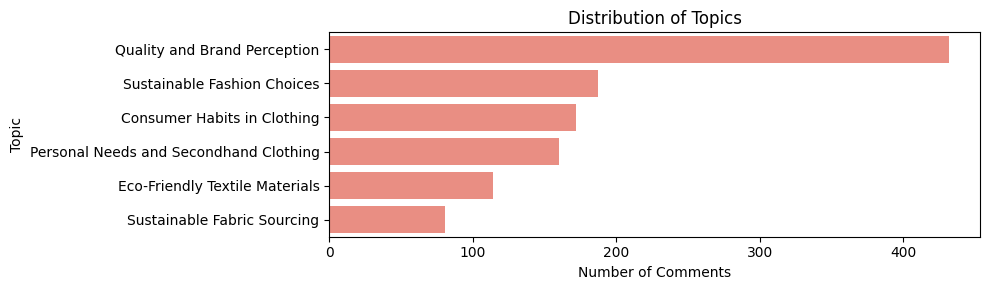

In [166]:
# Concatenate the DataFrames
df_combined = pd.concat([df, df_sentiment], axis=1)

# Update the 'assigned_topic' column with the labels from the dictionary
df_combined['assigned_topic'] = df_combined['assigned_topic'].map(topics_labels_dict)

# Visualization 1: Distribution of Topics (Horizontal)
plt.figure(figsize=(10, 3))
sns.countplot(y='assigned_topic', data=df_combined,
              order=df_combined['assigned_topic'].value_counts().index,
              color = 'salmon')
plt.title('Distribution of Topics')
plt.xlabel('Number of Comments')
plt.ylabel('Topic')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

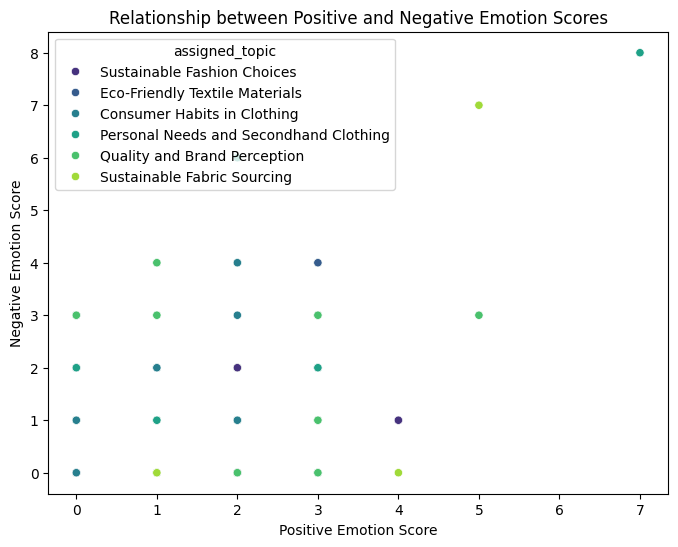

In [167]:
# Visualization 2: Relationship between Positive and Negative Emotion
plt.figure(figsize=(8, 6))
sns.scatterplot(x='positive_emotion', y='negative_emotion', data=df_combined, hue='assigned_topic', palette='viridis')
plt.title('Relationship between Positive and Negative Emotion Scores')
plt.xlabel('Positive Emotion Score')
plt.ylabel('Negative Emotion Score')
plt.show()

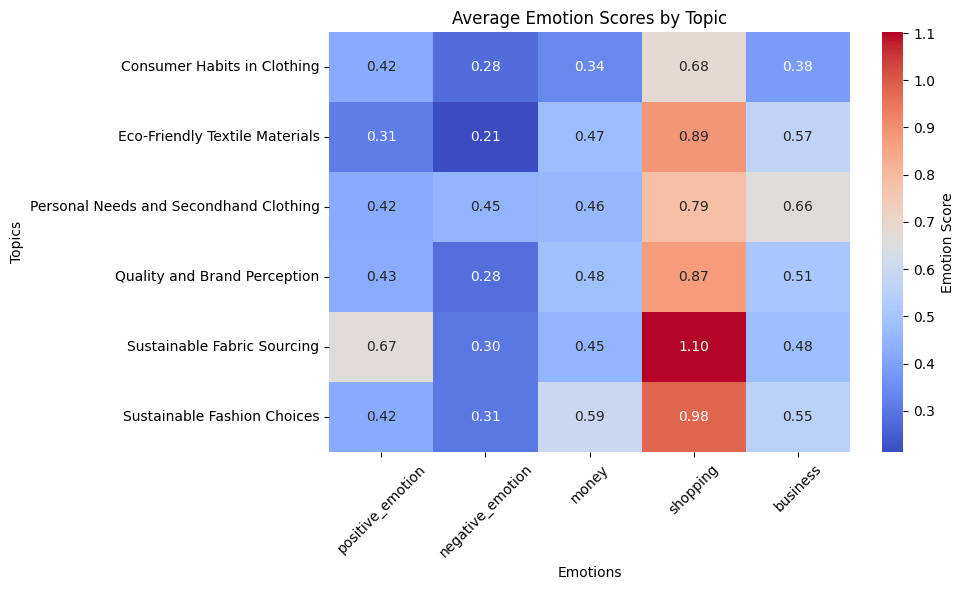

In [168]:
#Visualization 3 : Comparing Emotio scores across topics
# Calculate the average emotion scores for each topic
topic_emotion_avg = df_combined.groupby('assigned_topic')[['positive_emotion', 'negative_emotion', 'money', 'shopping', 'business']].mean()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_emotion_avg, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Emotion Score'})
plt.title('Average Emotion Scores by Topic')
plt.xlabel('Emotions')
plt.xticks(rotation=45)
plt.ylabel('Topics')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

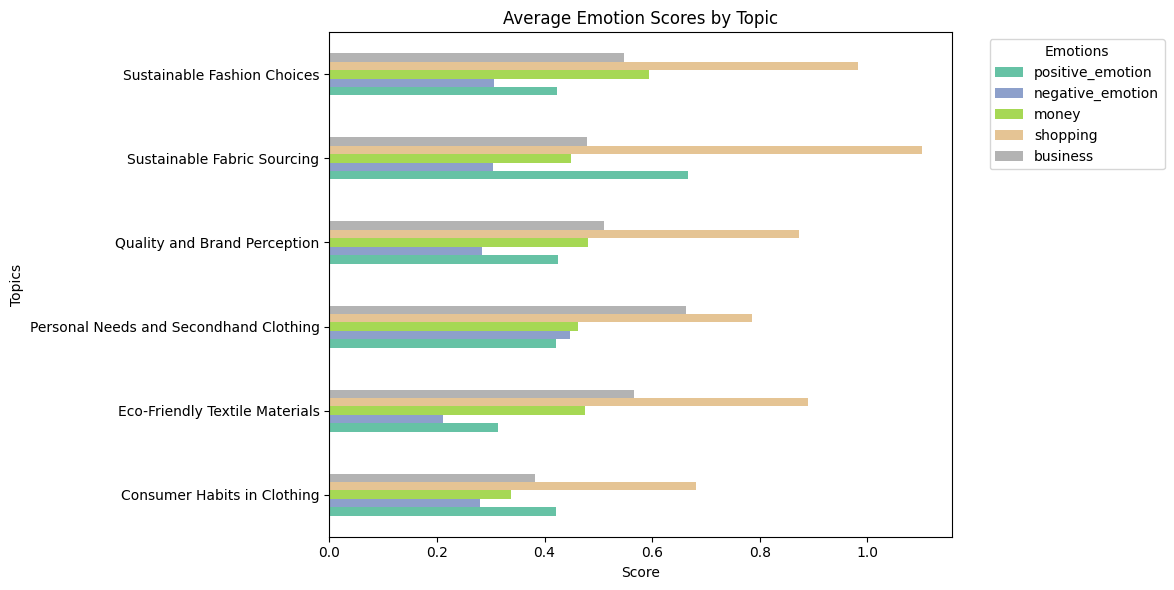

In [192]:
# Calculate the average emotion scores for each topic
topic_emotion_avg = df_combined.groupby('assigned_topic')[['positive_emotion', 'negative_emotion', 'money', 'shopping', 'business']].mean()

# Plot the raw emotion scores
plt.figure(figsize=(12, 6))
topic_emotion_avg.plot(kind='barh', stacked=False, figsize=(12, 6), colormap="Set2")
plt.title('Average Emotion Scores by Topic')
plt.xlabel('Score')
plt.ylabel('Topics')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

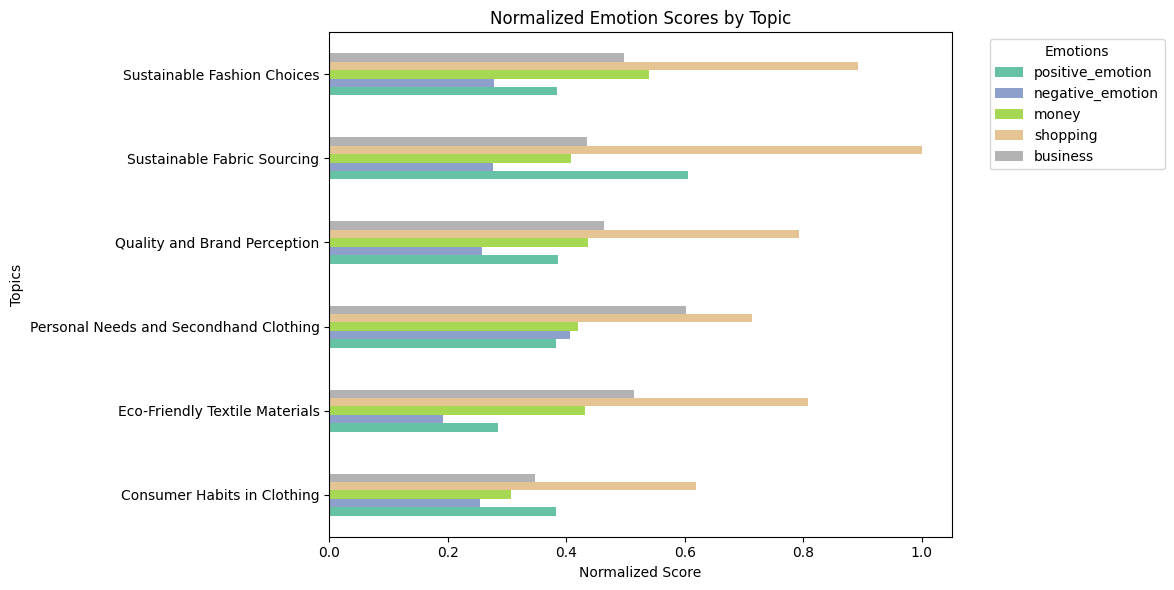

In [193]:
# Alternatively, normalize by the maximum score
topic_emotion_norm = topic_emotion_avg.div(topic_emotion_avg.max().max())

plt.figure(figsize=(12, 6))
topic_emotion_norm.plot(kind='barh', stacked=False, figsize=(12, 6), colormap="Set2")
plt.title('Normalized Emotion Scores by Topic')
plt.xlabel('Normalized Score')
plt.ylabel('Topics')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**4. Supervised Learning : Classification**

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assign dominant topic as target variable
dominant_topics = np.argmax(nmf_output, axis=1)
df['assigned_topic'] = dominant_topics

# Prepare features
X = doc_term_matrix
y = df['assigned_topic']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.89      0.65        35
           1       0.85      0.83      0.84        42
           2       0.74      0.45      0.56        31
           3       0.68      0.59      0.63        22
           4       0.82      0.83      0.83        89
           5       1.00      0.09      0.17        11

    accuracy                           0.73       230
   macro avg       0.77      0.61      0.61       230
weighted avg       0.77      0.73      0.72       230



In [185]:
from sklearn.svm import SVC

# Train SVM classifier
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train, y_train)

# Evaluate
svm_pred = svm_clf.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70        35
           1       1.00      0.62      0.76        42
           2       0.93      0.45      0.61        31
           3       1.00      0.14      0.24        22
           4       0.55      1.00      0.71        89
           5       0.00      0.00      0.00        11

    accuracy                           0.67       230
   macro avg       0.72      0.47      0.50       230
weighted avg       0.75      0.67      0.63       230



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [186]:
from xgboost import XGBClassifier

# Train XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=6,  # Number of topics
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb_clf.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.85      0.79      0.81        42
           2       0.73      0.61      0.67        31
           3       0.58      0.50      0.54        22
           4       0.73      0.90      0.81        89
           5       1.00      0.18      0.31        11

    accuracy                           0.75       230
   macro avg       0.78      0.63      0.66       230
weighted avg       0.76      0.75      0.74       230



In [187]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression classifier
lr_clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)

# Evaluate
lr_pred = lr_clf.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        35
           1       1.00      0.83      0.91        42
           2       0.80      0.65      0.71        31
           3       0.75      0.55      0.63        22
           4       0.73      0.96      0.83        89
           5       0.60      0.27      0.38        11

    accuracy                           0.81       230
   macro avg       0.80      0.69      0.73       230
weighted avg       0.82      0.81      0.80       230



Based on the classification results across different models for the sustainable fashion discourse analysis:

Logistic Regression emerged as the best performing model with:
- Highest overall accuracy: 81%
- Best weighted average F1-score: 0.80
- Most balanced performance across classes

Performance ranking from best to worst:
- Logistic Regression (81% accuracy)
- XGBoost (75% accuracy)
- Random Forest (73% accuracy)
- SVM (67% accuracy)

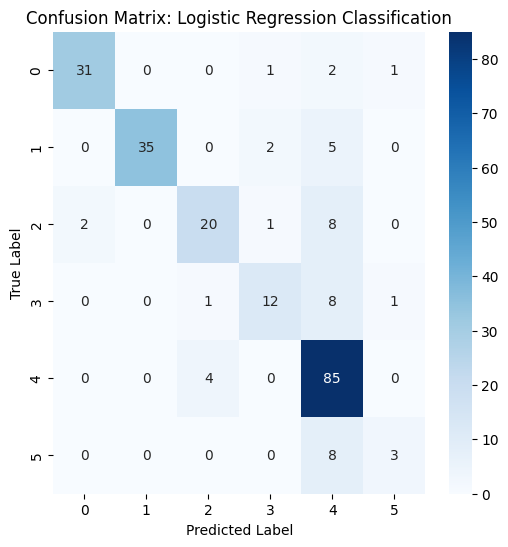

In [190]:
#Final Model : Logistic Regression lr_clf

from sklearn.metrics import confusion_matrix
## Visualization 1: Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

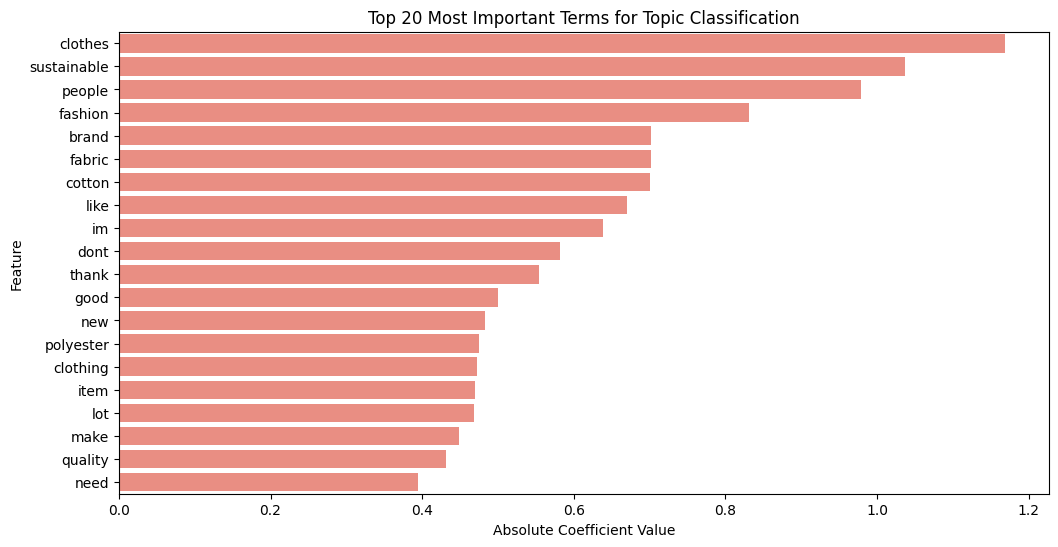

In [189]:
## Visualization 2: Feature Importance
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'coefficient': np.abs(lr_clf.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='coefficient', y='feature', color='salmon')
plt.title('Top 20 Most Important Terms for Topic Classification')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()